In [2]:
from support import CachedStanModel
import pandas as pd
import numpy as np
import pylab as pl
import arviz as az

In [3]:
#sig = pd.read_csv('psth_sig_cellids.csv')['cellid'].unique()
df = pd.read_csv('frequency_tuning_curves_for_bburan.csv')
df.columns = [s.replace(' ', '') for s in df.columns]
cols = ['pupil', 'frequency', 'ftc_count', 'ftc_time', 'spont_count', 'spont_time']
df = pd.wide_to_long(df, cols, 'cellid', 'idx', sep='_').dropna()
df['pupil'] -= 1
df['frequency'] = np.log2(df['frequency'])

#mask = df.apply(lambda x: x.name[0] in sig, axis=1)
#df = df.loc[mask]

sr = df.groupby(['cellid', 'pupil'])[['spont_count', 'spont_time']].first().sort_index()
ftc = df.reset_index().set_index(['cellid', 'pupil', 'frequency'])[['ftc_count', 'ftc_time']].sort_index()
m = ftc['ftc_time'] > 0
ftc = ftc.loc[m]

sig_cells = pd.read_csv('psth_sig_cellids.csv')
sig_cells['significant'] = True
sig_cells = sig_cells.set_index('cellid')
ftc = ftc.reset_index().join(sig_cells, on=sig_cells.index.names).set_index(ftc.index.names)
ftc['significant'] = ftc['significant'].fillna(False)

sr = sr.reset_index().join(sig_cells, on=sig_cells.index.names).set_index(sr.index.names)
sr['significant'] = sr['significant'].fillna(False)

In [66]:
import importlib
import support
importlib.reload(support)
model = support.CachedStanModel('ftc_nosr_V2b.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e63fa5fdfe846c17f4211fe359191cb5 NOW.
/home/bburan/bin/miniconda3/envs/ohsu-python3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpx2fuwnah/stanfit4anon_model_e63fa5fdfe846c17f4211fe359191cb5_6003988612147710634.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
#cells = ftc.index.get_level_values('cellid').unique()
#cs, ce = cells[0], cells[5]
#f = ftc.loc[cs:ce].reset_index()
#s = sr.loc[cs:ce].reset_index()

f = ftc.reset_index()
s = sr.reset_index()

cells = f['cellid'].unique()
cell_map = {c: i+1 for i, c in enumerate(cells)}
cell_index = f['cellid'].apply(cell_map.get).values

# Must clip spont count since we have a multiplicative term. If spont is 0, model can't do anything!
s['cell_index'] = s['cellid'].map(cell_map.get)
s['spont_count_clipped'] = s['spont_count'].clip(lower=1, upper=np.inf)
s = s.set_index(['pupil', 'cell_index'])[['spont_count_clipped', 'spont_time']] \
    .sort_index().eval('spont_count_clipped/spont_time').unstack('pupil').reset_index()
sr_cell = s[0].values
sr_cell_pupil = s[1].values

data = {
    'n': len(f),
    'n_cells': len(cells),
    'cell_index': cell_index,
    'freq': f['frequency'].values,
    'pupil': f['pupil'].values.astype('i'),
    'time': f['ftc_time'].values,
    'count': f['ftc_count'].values.astype('i'),
    'sr': sr_cell,
    'sr_pupil': sr_cell_pupil,
}


fit = model.sampling(data, iter=20000, control={'adapt_delta': 0.999, 'max_treedepth': 20})
fit

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52c89c90b8>,
      dtype=object)

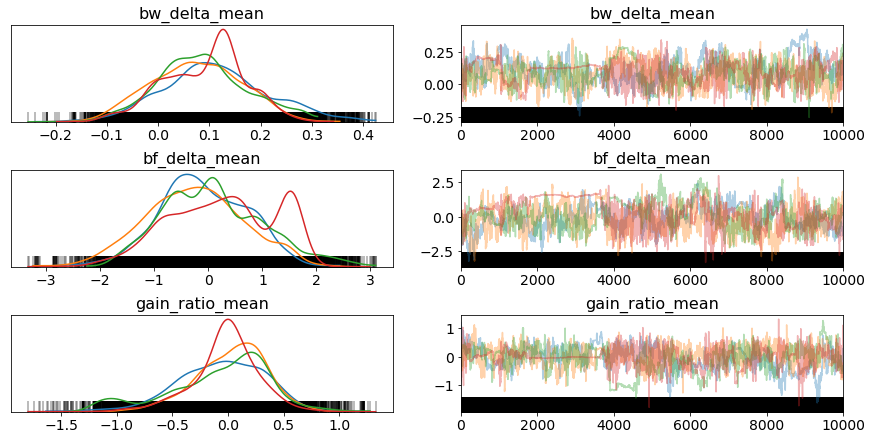

In [71]:
az.plot_trace(fit, ['bw_delta_mean', 'bf_delta_mean', 'gain_ratio_mean'])

4.398983269775116 4.040234676050577 33.054177484361986
8.566647195349738 4.957749243183046 -0.5542580406249441
5.781190485432728 2.6327705204538687 7.170421424341438
6.983464324242873 5.94733436027495 -3.0762432981045937
12.719906320854484 4.8570823144501984 -2.6484301345747836
8.623105489239672 2.3601757014570808 33.000484201248284


IndexError: index 6 is out of bounds for axis 0 with size 6

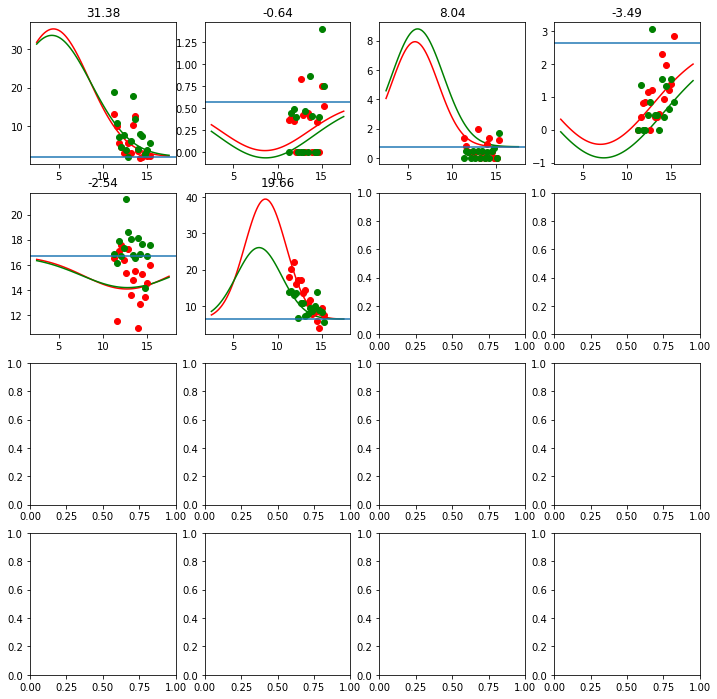

In [72]:
def plot_fit(ax, c, i, cells, ftc, sr_cell, sr_cell_pupil):
    cell = cells[i]

    bf = c[f'bf_cell[{i+1}]']
    bw = c[f'bw_cell[{i+1}]']
    gain = c[f'gain_cell[{i+1}]']
    
    frequency = np.linspace(2.5, 17.5, 100)
    
    s = sr_cell[i]
    s_d = sr_cell_pupil[i]
    
    bw = np.exp(bw)
    print(bf, bw, gain)
    gauss = gain * np.exp(-0.5 * np.square((frequency-bf)/bw))
    l = s + gauss
    ax.plot(frequency, l, 'r-')
    
    bf = c[f'bf_cell[{i+1}]'] + c[f'bf_cell_delta[{i+1}]']
    bw = c[f'bw_cell[{i+1}]'] + c[f'bw_cell_delta[{i+1}]']
    gain = c[f'gain_cell[{i+1}]'] * np.exp(c[f'gain_cell_ratio[{i+1}]'])
    
    bw = np.exp(bw)
    gauss = gain * np.exp(-0.5 * np.square((frequency-bf)/bw))
    l = s + gauss
    ax.plot(frequency, l, 'g-')

    x = ftc.loc[cell, 0]
    x = x.eval('ftc_count/ftc_time').rename('rate').reset_index()
    ax.plot(x['frequency'], x['rate'], 'ro')
    
    x = ftc.loc[cell, 1]
    x = x.eval('ftc_count/ftc_time').rename('rate').reset_index()
    ax.plot(x['frequency'], x['rate'], 'go')
    ax.axhline(s)
    ax.set_title(f'{gain:0.2f}')
    
    
c = fit.to_dataframe(diagnostics=False).mean()
f, axes = pl.subplots(4, 4, figsize=(12, 12))

for i, ax in zip(range(15), axes.ravel()):
    plot_fit(ax, c, i, cells, ftc, sr_cell, sr_cell_pupil)

In [ ]:
def plot_fit(ax, fit, data):
    bf = fit['bf'].mean()
    gain = fit['gain'].mean()
    bw = fit['bw'].mean()
    offset = data['sr']

    frequency = np.arange(3, 11, 0.1)
    l = np.exp(-0.5*np.square((frequency-bf)/bw))
    l = offset + gain * l
    ax.plot(np.exp(frequency), l, ':', color='orchid', label='Sm. pupil')
    ax.axhline(offset, color='orchid')

    bf += fit['bf_pupil_delta'].mean()
    gain += fit['gain_pupil_delta'].mean()
    bw += fit['bw_pupil_delta'].mean()
    offset = data['sr_lg']
    l = np.exp(-0.5*np.square((frequency-bf)/bw))
    l = offset + gain * l
    ax.plot(np.exp(frequency), l, ':', color='seagreen', label='Lg. pupil')
    ax.axhline(offset, color='seagreen')

    pupil = data['pupil']
    frequency = data['freq']
    evoked_rate = data['spike_count'] / data['sample_time']
    #spont_rate = data['spont_count'] / data['spont_time']

    m_pupil = pupil == 0
    ax.plot(np.exp(frequency[m_pupil]), evoked_rate[m_pupil], 'o-', color='orchid')
    m_pupil = pupil == 1
    ax.plot(np.exp(frequency[m_pupil]), evoked_rate[m_pupil], 'o-', color='seagreen')

    #ax.axhline(spont_rate[0], color='orchid', ls=':', lw=2)
    #ax.axhline(spont_rate[1], color='seagreen', ls=':', lw=2)
    ax.set_xscale('log')

f, axes = pl.subplots(10, 12, figsize=(20, 20))

for ax, (cell, fit) in zip(axes.ravel(), fits.items()):
    data = get_cell_data(cell, ftc, sr)
    plot_fit(ax, fit, data)
    
ax.legend()

In [ ]:
def plot_fit(ax, fit, data):
    bf = fit['bf'].mean()
    gain = fit['gain'].mean()
    bw = fit['bw'].mean()
    offset = data['sr']

    frequency = np.arange(3, 11, 0.1)
    l = np.exp(-0.5*np.square((frequency-bf)/bw))
    l = offset * gain * l
    ax.plot(np.exp(frequency), l, ':', color='orchid', label='Sm. pupil')
    ax.axhline(offset, color='orchid')

    bf += fit['bf_delta'].mean()
    gain *= fit['gain_ratio'].mean()
    bw *= fit['bw_ratio'].mean()
    offset = data['sr_lg']
    l = np.exp(-0.5*np.square((frequency-bf)/bw))
    l = offset * gain * l
    ax.plot(np.exp(frequency), l, ':', color='seagreen', label='Lg. pupil')
    ax.axhline(offset, color='seagreen')

    pupil = data['pupil']
    frequency = data['freq']
    evoked_rate = data['spike_count'] / data['sample_time']
    #spont_rate = data['spont_count'] / data['spont_time']

    m_pupil = pupil == 0
    ax.plot(np.exp(frequency[m_pupil]), evoked_rate[m_pupil], 'o-', color='orchid')
    m_pupil = pupil == 1
    ax.plot(np.exp(frequency[m_pupil]), evoked_rate[m_pupil], 'o-', color='seagreen')

    #ax.axhline(spont_rate[0], color='orchid', ls=':', lw=2)
    #ax.axhline(spont_rate[1], color='seagreen', ls=':', lw=2)
    ax.set_xscale('log')

f, axes = pl.subplots(10, 12, figsize=(20, 20))

for ax, (cell, fit) in zip(axes.ravel(), fits.items()):
    data = get_cell_data(cell, ftc, sr)
    plot_fit(ax, fit, data)
    
ax.legend()

In [ ]:
results = [az.summary(f, credible_interval=0.9).to_dataframe() for f in fits.values()]
results = pd.concat(results, keys=fits.keys(), names=['cell'])

In [ ]:
results.head()

In [ ]:
def plot(ax, df, measure):
    m = df['mean']
    lb = df['hpd 5.00%']
    ub = df['hpd 95.00%']
    gr = df['gelman-rubin statistic']
    stat = stats.wilcoxon(m)

    #ax.axvline(0)
    #t = ax.get_xaxis_transform()
    #fc = 'lightgreen' if (ensemble_lb > 0) or (ensemble_ub < 0) else 'gray'
    #c = 'seagreen' if (ensemble_lb > 0) or (ensemble_ub < 0) else 'k'
    #ax.axvline(ensemble_m, color=c)
    #r = mp.patches.Rectangle((ensemble_lb, 0), ensemble_ub-ensemble_lb, 1,
    #                         transform=t, ec='none', fc=fc)
    #ax.add_patch(r)
    n_sig =0 
    for i, (a, d, b, g) in enumerate(zip(lb, m, ub, gr)):
        if g > 1.1:
            c = 'r'
        else:
            c = 'g' if (b < 0) or (a > 0) else 'k'
            n_sig += 1 if (b < 0) or (a > 0) else 0
        ax.plot([a, b], [i, i], '-', color=c, lw=0.5)
        ax.plot([d], [i], 'o', color=c)
        
    ax.set_xlabel(f'Change in {measure} (lg. re sm. pupil)\n{n_sig} sig. out of {len(lb)}\nWilcoxon p={stat.pvalue:0.4f}')
    sns.despine(ax=ax, top=True, left=True, right=True, bottom=False)
    ax.yaxis.set_ticks_position('none')
    ax.yaxis.set_ticks([])
    ax.grid()
    return ax


import seaborn as sns
from scipy import stats
bf_pupil_delta = results['bf_pupil_delta'].unstack().sort_values('mean')
bw_pupil_delta = results['bw_pupil_delta'].unstack().sort_values('mean')
gain_pupil_delta = results['gain_pupil_delta'].unstack().sort_values('mean')


f, axes = pl.subplots(1, 3, figsize=(9, 3))

plot(axes[0], bf_pupil_delta, 'BF')
plot(axes[1], bw_pupil_delta, 'BW')
plot(axes[2], gain_pupil_delta, 'gain')

In [ ]:
m = bw_pupil_delta['gelman-rubin statistic'] < 1.1
np.median(bw_pupil_delta.loc[m]['mean'])